<a href="https://colab.research.google.com/github/dpostolovski/eeg_is/blob/master/IS_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>
  <img alt="FINKI **LOGO**" height="30px" src="https://www.finki.ukim.mk/Content/dataImages/downloads/logo-large-500x500_2.png" hspace="10px" vspace="0px">
  Интелигентни системи - Лабораториска вежба 2 (Претпроцесирање)
</h1>
<center><h3><i>Група 5<i><h3></center>

---



In [0]:
#@title Монтирање на Google Drive податочниот систем
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#@title Инсталирање и вчитување на потребните библиотеки

# Библиотека за истражување, визуелизација и анализирање на човечки 
# неврофизиолошки податоци (EEG, sEEG и др)
!pip install mne 
!pip install termcolor

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
from termcolor import colored

## Вчитување на податоците
Податоците ги вчитуваме во променливата data. Вчитаните податоци се претставени со тридимензионална матрица со димензии 8 канали X 350 епохи X 1600 настани, но за потребите на mne библиотеката првите две димензии треба да ги замениме.

In [0]:
# Вчитување на податоците
data = loadmat('drive/My Drive/Интелигентни Системи/Data/S01-Train/trainData.mat')['trainData'] 

# Вчитување на label-ите
labels_arr = []
with open("drive/My Drive/Интелигентни Системи/Data/S01-Train/trainLabels.txt", "r") as file_labels:
    labels_arr = file_labels.read().splitlines()

# Вчитување на редоследот на светкање
events_arr = []
with open("drive/My Drive/Интелигентни Системи/Data/S01-Train/trainEvents.txt", "r") as file_labels:
    events_arr = file_labels.read().splitlines()

# Вчитување на редоследот на објекти кои се target
targets_arr = []
with open("drive/My Drive/Интелигентни Системи/Data/S01-Train/trainTargets.txt", "r") as file_labels:
    targets_arr = file_labels.read().splitlines()

# Прилагодување на податоците за користење со mne библиотеката
ch_names = ["C3", "Cz", "C4", "CPz", "P3", "Pz", "P4", "POz"]
ch_types = ['eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg']
mne_info = mne.create_info(ch_names=ch_names, sfreq=250, ch_types=ch_types)
mne_array = np.swapaxes(data, 0, 1) # (епохa, канал, настан). 
raw_data = mne.epochs.EpochsArray(mne_array, mne_info)

if data.shape[0] == 8:
  print("Податоците се успешно вчитани.")
else:
  print("Настана грешка во вчитувањето на податоците.")

## Визуелизација на податоците

Creating RawArray with float64 data, n_channels=65, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


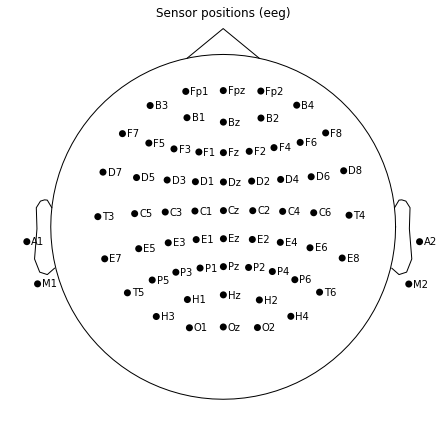

In [230]:
#@title Локација на сензорите
#@markdown Може да се забележи дека каналите кои ги отчитуваме се наоѓаат во средниот и задниот дел на мозокот.
montage = mne.channels.make_standard_montage("standard_alphabetic")
montage.plot();

Creating RawArray with float64 data, n_channels=8, n_times=1600
    Range : 0 ... 1599 =      0.000 ...     6.396 secs
Ready.


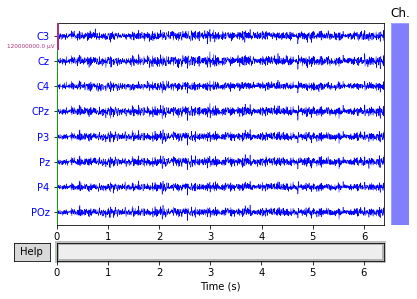

Effective window size : 6.400 (s)


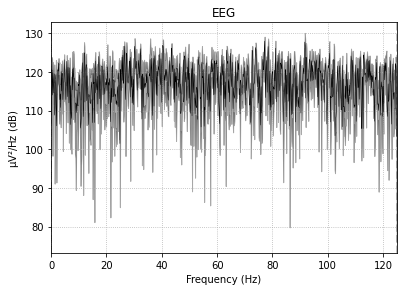

In [232]:
#@title Визуелизација на EEG сигналите во 175 епоха.
#@markdown 1. Визуелизација на EEG податоците по канали.
#@markdown 2. Power Spectrum Density на 175-тата епоха. 
#@markdown * Ја избравме оваа епоха бидејќи
#@markdown тука сигналите би биле најстабилни за објектот кој светка.

epoch = mne_array[175]
raw = mne.io.RawArray(epoch, mne_info)

raw.plot(n_channels=8, scalings=dict(eeg=60), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'))
raw.plot_psd(area_mode='range', show=False, average=True);

Creating RawArray with float64 data, n_channels=8, n_times=200
    Range : 0 ... 199 =      0.000 ...     0.796 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=100
    Range : 0 ... 99 =      0.000 ...     0.396 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=200
    Range : 0 ... 199 =      0.000 ...     0.796 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=100
    Range : 0 ... 99 =      0.000 ...     0.396 secs
Ready.



====== ПРВ ОБЈЕКТ - Книги на полица ======
Вкупно светнал: 200
Вкупно светнал и бил target: 100


====== ПОСЛЕДЕН ОБЈЕКТ - Слика закачена на ѕид ======
Вкупно светнал: 200
Вкупно светнал и бил target: 100


====== Графици со EEG податоци кога светнале првиот и последниот објект  ======


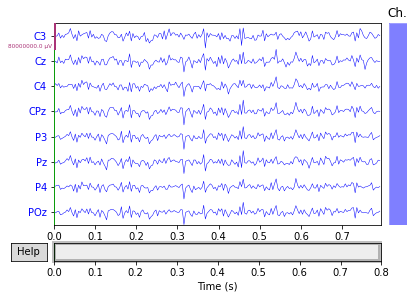

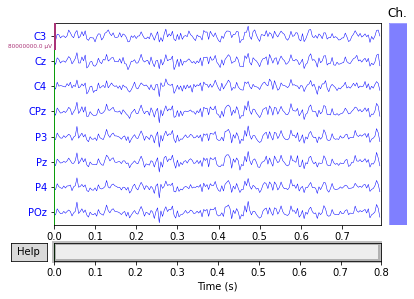



====== Графици со EEG податоци кога светнале првиот и последниот објект и биле target  ======


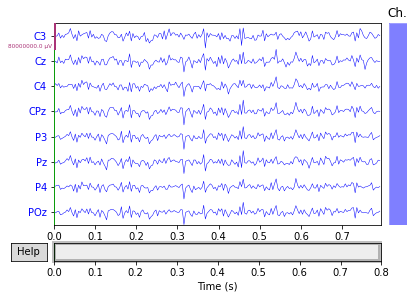

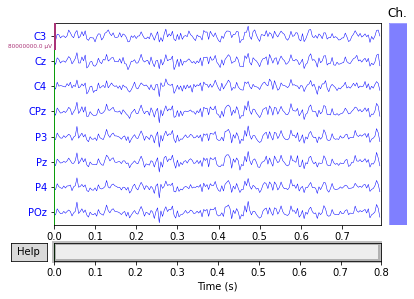

In [234]:
#@title Визуелизирана споредба на EEG податоците при светкање на првиот и последниот објект  
#@markdown Во првиот случај вршиме споредба на EEG податоците кога првиот и последниот, 
#@markdown објектот светнал без разлика дали бил target, додека во вториот случај ги споредуваме
#@markdown EEG податоците за случаи кога тие објекти светнале, но воедно биле и target објекти.

# Извлекување на настаните каде светнал првиот објект.
first_object_events = [index for index, value in enumerate(events_arr) if value == '1']
first_object_eeg_data = np.zeros((8,350, len(first_object_events)))
for channel in range(0, 8): # Секој канал
  for epoch in range(0, 350): # Секоја епоха
    i = 0
    for event in first_object_events: # Настан
      first_object_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      i = i+1

# Креирање на соодветна дводимензионална низа за mne библиотеката
mne_first_obj_array = np.swapaxes(first_object_eeg_data, 0, 1) # (епохa, канал, настан).
epoch = mne_first_obj_array[175] 
first_object_raw = mne.io.RawArray(epoch, mne_info)





# Извлекување на настаните каде светнал првиот објект и бил target.
first_object_events_target = [index for index, value in enumerate(events_arr) if value == '1']
for event_pos in first_object_events_target:
  if targets_arr[event_pos] == 1:
    continue # Продолжи
  else:
    first_object_events_target.remove(event_pos) # Избриши -> Објектот не е target
first_object_target_eeg_data = np.zeros((8,350, len(first_object_events_target)))
for channel in range(0, 8): # Секој канал
  for epoch in range(0, 350): # Секоја епоха
    i = 0
    for event in first_object_events_target: # Настан
      first_object_target_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      i = i+1

# Креирање на соодветна дводимензионална низа за mne библиотеката
mne_first_obj_target_array = np.swapaxes(first_object_target_eeg_data, 0, 1) # (епохa, канал, настан).
epoch = mne_first_obj_target_array[175] 
first_object_target_raw = mne.io.RawArray(epoch, mne_info)





# Извлекување на настаните каде светнал последниот објект.
last_object_events = [index for index, value in enumerate(events_arr) if value == '8']
last_object_eeg_data = np.zeros((8,350, len(last_object_events)))
for channel in range(0, 8): # Секој канал
  for epoch in range(0, 350): # Секоја епоха
    i = 0
    for event in last_object_events: # Настан
      last_object_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      i = i+1

# Креирање на соодветна дводимензионална низа за mne библиотеката
mne_last_obj_array = np.swapaxes(last_object_eeg_data, 0, 1) # (епохa, канал, настан).
epoch = mne_last_obj_array[175] 
last_object_raw = mne.io.RawArray(epoch, mne_info)





# Извлекување на настаните каде светнал последниот објект и бил target.
last_object_events_target = [index for index, value in enumerate(events_arr) if value == '8']
for event_pos in last_object_events_target:
  if targets_arr[event_pos] == 1:
    continue # Продолжи
  else:
    last_object_events_target.remove(event_pos) # Избриши -> Објектот не е target
last_object_target_eeg_data = np.zeros((8,350, len(last_object_events_target)))
for channel in range(0, 8): # Секој канал
  for epoch in range(0, 350): # Секоја епоха
    i = 0
    for event in last_object_events_target: # Настан
      last_object_target_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      i = i+1
      
# Креирање на соодветна дводимензионална низа за mne библиотеката
mne_last_obj_target_array = np.swapaxes(last_object_target_eeg_data, 0, 1) # (епохa, канал, настан).
epoch = mne_last_obj_target_array[175] 
last_object_target_raw = mne.io.RawArray(epoch, mne_info)





# Исцртување и печатење
print("\n\n")
print(colored('====== ПРВ ОБЈЕКТ - Книги на полица ======', 'red'))
print(colored("Вкупно светнал: " + str(len(first_object_events)), 'blue'))
print(colored("Вкупно светнал и бил target: " + str(len(first_object_events_target)), 'blue'))
print("\n")
print(colored('====== ПОСЛЕДЕН ОБЈЕКТ - Слика закачена на ѕид ======', 'red'))
print(colored("Вкупно светнал: " + str(len(last_object_events)), 'blue'))
print(colored("Вкупно светнал и бил target: " + str(len(last_object_events_target)), 'blue'))
print("\n")
print(colored('====== Графици со EEG податоци кога светнале првиот и последниот објект  ======', 'green'))
first_object_raw.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'));
last_object_raw.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'));
print("\n")
print(colored('====== Графици со EEG податоци кога светнале првиот и последниот објект и биле target  ======', 'green'))
first_object_raw.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'));
last_object_raw.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'));